### NLP Assignment

In [3]:
import nltk
import pandas as pd
import nltk.data
import os
import keras

Using TensorFlow backend.


In [4]:
######## Loading the important keras modules  ##############


### Reading the text data with Pandas

In [5]:

path = "G:\\Internship_assignment\\Niki.ai\\Question.txt"
text_data = pd.read_csv(path, sep=',,,',header=None)
text_data.columns = ['Description','Label']

C:\Users\rahul\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


In [6]:
text_data.head()

Description     Label
0  how did serfdom develop in and then leave russ...   unknown
1  what films featured the character popeye doyle ?       what
2  how can i find a list of celebrities ' real na...   unknown
3  what fowl grabs the spotlight after the chines...      what
4                   what is the full form of .com ?       what

In [7]:
## Maximum length of the a senetence in description
text_data['Description'].apply(len).max()

173

### checking the class distribution of lables

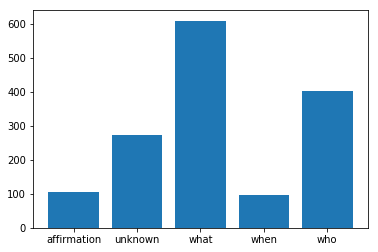

In [8]:
## Draw bargraph for each of the class
import matplotlib.pyplot as plt

y_ = text_data['Label'].values.tolist()
y = [i.strip() for i in y_]
y = pd.Series(data=y)
y = y.value_counts()

plt.bar(y.index, height = y.values )
plt.show()

### Baseline Model: Using SVM with tf-idf Vectorizer

In [9]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)


** Text pre-processing **

In [10]:
### Sentence tokenization
import nltk.data
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

lemmatizer =  WordNetLemmatizer()

corpus = text_data['Description'].values.tolist()
word_corpus_ = [i.split(' ')[:-2] for i in corpus]
word_corpus = []
for i in word_corpus_:
    temp = []
    for j in i:
        temp.append(lemmatizer.lemmatize(j))
    word_corpus.append(temp)
    

cleaned_corpus = [" ".join(i) for i in word_corpus]

**Feature Extraction using Tf-idf**

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 1),sublinear_tf=True,
                             max_df=0.95,min_df = 0.002)
vectorizer.fit(cleaned_corpus)

tdm = vectorizer.fit_transform(cleaned_corpus)
tdm.shape

(1483, 630)

**Reducing the dimensionality of the sparse vectors using LSA**

In [12]:
from sklearn.decomposition import TruncatedSVD

reducer = TruncatedSVD(n_components = 100, random_state = 1)
reduced_dimensions = reducer.fit_transform(tdm)

In [117]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

y_ = text_data['Label'].values.tolist()
y = [i.strip() for i in y_]

y = encoder.fit_transform(y)
X = reduced_dimensions

train_size = int(len(y)*0.8)
X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]


array(['affirmation', 'unknown', 'what', 'when', 'who'],
      dtype='<U11')

In [14]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split


model = LinearSVC(C=0.7,class_weight = 'balanced')
model.fit(X_train,y_train)

LinearSVC(C=0.7, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [16]:
#Training accuracy
model.score(X_train,y_train)

0.97470489038785835

In [17]:
#Test accuracy
model.score(X_test, y_test)

0.70033670033670037

### Hyperparameter tunning for Support Vector classifier 

Creating a pipeline for tuning the parameters used in every step from feature extraction to training model using crossvalidation strategy

In [228]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([('vect',TfidfVectorizer()),('reducer',TruncatedSVD()),
                    ('clf',LinearSVC())])

parameters = {
    'vect__max_df': (0.9,0.95,0.98),
    'vect__min_df': (0.001,0.002,0.004),
    'vect__ngram_range': ((1,1),(1,2)),
    'reducer__n_components': (80,100,120,140),
    'clf__C': (0.2,0.5,1.7,1.0,2.0,4.0,5.0,8.0,20,30),
    'clf__class_weight': (None, 'balanced')
}

grid_search = GridSearchCV(pipeline,parameters, n_jobs=-1,verbose=1)
grid_search.fit(cleaned_corpus[:train_size], y_train)

Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:  8.8min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__min_df': (0.001, 0.002, 0.004), 'clf__C': (0.2, 0.5, 1.7, 1.0, 2.0, 4.0, 5.0, 8.0, 20, 30), 'clf__class_weight': (None, 'balanced'), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__max_df': (0.9, 0.95, 0.98), 'reducer__n_components': (80, 100, 120, 140)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [231]:
## Best parameter tuned after the gridSearch
grid_search.best_params_

{'clf__C': 5.0,
 'clf__class_weight': None,
 'reducer__n_components': 120,
 'vect__max_df': 0.95,
 'vect__min_df': 0.001,
 'vect__ngram_range': (1, 1)}

In [230]:
grid_search.best_score_

0.96290050590219223

## Test error estimate using the best parameters tuned

In [248]:
grid_search.score(cleaned_corpus[train_size:], y_test)

0.6262626262626263

### Using the MultinomialNaive Bayes Classifier for high dimensional data


In [18]:
from sklearn.feature_extraction.text import CountVectorizer
c_vect = CountVectorizer(max_df = 0.95,min_df = 0.02)
c_tdm = c_vect.fit_transform(cleaned_corpus)


In [19]:
c_tdm.shape

(1483, 35)

In [20]:
from sklearn.naive_bayes import MultinomialNB


M_model = MultinomialNB()
M_model.fit(c_tdm[:train_size], y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [21]:
#Training Score
M_model.score(c_tdm[:train_size],y_train)

0.9300168634064081

In [22]:
#Test Score
M_model.score(c_tdm[train_size:], y_test)

0.6262626262626263

### Using the Regularized Logistic Regression 

In [23]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C = 1.0,penalty='l2',class_weight = 'balanced',
                         solver = 'lbfgs',max_iter = 500,
                        multi_class='multinomial',random_state=42)
clf.fit(X_train, y_train)
clf.coef_.shape

(5, 100)

In [24]:
#Training score
clf.score(X_train,y_train)

0.96795952782462058

In [25]:
#Test score
clf.score(X_test, y_test)

0.73737373737373735

## Creating pipeline for Hypertuning the Logistic Regression parameters

In [26]:
############### Avoid running this cell unless you have lot of time, it will take altleast one hour to complete ################

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


classifier = LogisticRegression(class_weight='balanced',warm_start=True,
                                multi_class='multinomial',solver='saga',max_iter=500)
pipeline = Pipeline([('vect',TfidfVectorizer()),('reducer',TruncatedSVD()),
                    ('clf',classifier)])

parameters = {
    'vect__max_df': (0.9,0.95,0.98),
    'vect__min_df': (0.001,0.002,0.004),
    'reducer__n_components': (60,80,100,120,140,150),
    'clf__C': (0.2,0.5,0.7,1.0,2.0,4.0,5.0,8.0,20.0,30.0),
    'clf__penalty': ('l1','l2')
}

grid_search = GridSearchCV(pipeline,parameters, scoring='accuracy',cv=3,n_jobs=-1,verbose=1)
grid_search.fit(cleaned_corpus[:train_size],y_train)


Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 38.6min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 51.9min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 69.6min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 70.5min finished
C:\Users\rahul\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...l2',
          random_state=None, solver='saga', tol=0.0001, verbose=0,
          warm_start=True))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__max_df': (0.9, 0.95, 0.98), 'clf__penalty': ('l1', 'l2'), 'clf__C': (0.2, 0.5, 0.7, 1.0, 2.0, 4.0, 5.0, 8.0, 20.0, 30.0), 'vect__min_df': (0.001, 0.002, 0.004), 'reducer__n_components': (60, 80, 100, 120, 140, 150)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [27]:
grid_search.best_score_

0.9595278246205734

In [28]:
grid_search.best_params_

{'clf__C': 30.0,
 'clf__penalty': 'l2',
 'reducer__n_components': 150,
 'vect__max_df': 0.98,
 'vect__min_df': 0.001}

### Test error estimation using fine tuned parameters for logistic regression

In [30]:
grid_search.score(cleaned_corpus[train_size:], y_test)

0.67003367003366998

## Deep learning model for Text classification

The deep learning model is not useful for such a small sized text data sets. However i gave a try to neural network model with sentence converted to vectors using word2vec model. 

In [134]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.models import Model

In [135]:
max_words = 500
batch_size = 32
epochs = 5
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(cleaned_corpus)

In [136]:
word_index = tokenizer.word_index
MAX_SEQUENCE_LENGTH = 24
sequences = sequences = tokenizer.texts_to_sequences(cleaned_corpus)
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(y))
X_train, X_test, y_train, y_test = train_test_split(data, labels,test_size = 0.2)

In [137]:
glove_dir = 'G:\MACHINE_LEARNING\Deep_learning\deep_learning_keras_model_code\Summer_project\glove_vectors'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


In [138]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [139]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [140]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 24, 100)           343900    
_________________________________________________________________
flatten_6 (Flatten)          (None, 2400)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 12005     
Total params: 355,905
Trainable params: 355,905
Non-trainable params: 0
_________________________________________________________________


In [141]:
history = model.fit(X_train, y_train, epochs = 30,validation_data = (X_test, y_test), verbose=2)

Train on 1186 samples, validate on 297 samples
Epoch 1/30
 - 1s - loss: 1.4473 - acc: 0.3904 - val_loss: 1.6237 - val_acc: 0.5320
Epoch 2/30
 - 0s - loss: 1.1486 - acc: 0.5489 - val_loss: 1.1882 - val_acc: 0.5556
Epoch 3/30
 - 0s - loss: 0.9446 - acc: 0.6417 - val_loss: 1.2816 - val_acc: 0.4545
Epoch 4/30
 - 0s - loss: 0.7748 - acc: 0.7361 - val_loss: 1.6037 - val_acc: 0.4040
Epoch 5/30
 - 0s - loss: 0.6694 - acc: 0.7884 - val_loss: 1.1689 - val_acc: 0.5051
Epoch 6/30
 - 0s - loss: 0.5560 - acc: 0.8196 - val_loss: 0.8246 - val_acc: 0.7172
Epoch 7/30
 - 0s - loss: 0.4587 - acc: 0.8668 - val_loss: 0.7027 - val_acc: 0.7508
Epoch 8/30
 - 0s - loss: 0.3853 - acc: 0.8938 - val_loss: 0.5716 - val_acc: 0.8114
Epoch 9/30
 - 0s - loss: 0.3154 - acc: 0.9258 - val_loss: 0.5185 - val_acc: 0.8182
Epoch 10/30
 - 0s - loss: 0.2644 - acc: 0.9334 - val_loss: 0.8658 - val_acc: 0.6195
Epoch 11/30
 - 0s - loss: 0.2314 - acc: 0.9435 - val_loss: 0.5983 - val_acc: 0.8013
Epoch 12/30
 - 0s - loss: 0.1841 - acc

In [142]:
# Plotting the training and validation accuracy for the given data set
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Evaluating the model performance on test data**

In [147]:
## Evaluate the model on test data
score = model.evaluate(X_test, y_test)
print('The test accuracy on the above data set is {}'.format(score[1]))

297/297 [==============================] - 0s 54us/step
The test accuracy on the above data set is 0.898989899391277


### Results from the best model experimented above

In [176]:
a = np.random.randint(0,300,size=15).tolist()
test_samples_ = [cleaned_corpus[i] for i in a]

test_samples = tokenizer.texts_to_sequences(test_samples_)
test_samples = pad_sequences(test_samples, maxlen=MAX_SEQUENCE_LENGTH)


In [178]:
pred = model.predict(test_samples)
pred = np.argmax(pred, axis = 1)
for i,j in zip(test_samples_, pred):
    print('{}   :    {}'.format(i, encoder.classes_[j]))

what la vega hotel burned in november , 1980 , with the loss of 84 life   :    what
name a golf course in myrtle beach   :    unknown
what country do the galapagos island belong to   :    what
what did delilah do to samson 's hair   :    what
what explorer wa nicknamed iberia 's pilot   :    what
what is the origin of the name katie   :    what
who wa the pride of the yankee   :    who
what is the size of the largest akita   :    what
name a golf course in myrtle beach   :    unknown
who were the five marx brother   :    who
who is the mayor of marbella   :    who
what sea did the roman call mare nostrum   :    what
what are other way of getting stretch mark besides pregnancy , weight loss , and weight lifting   :    what
who wa the 16th president of the united state   :    who
what la vega hotel burned in november , 1980 , with the loss of 84 life   :    what


# Conclusions:

I tried different models for text classification of given data set. The whole kernel describes my experiment with the different machine learning models. Firt i tried classical machine learning model like SVM, MultinomialNaiveBayes and Logistic Regression. SVM is consider good for treating high dimensions in data set. However the data set provided was so small from text classification perspective that it memorize the training data and perform poorly on test data. The same thing happened with other classical ML model. Surprisingly the simpler model like Logistic Regression outperforms SVM on test accuracy. The parameters for SVM and Logistic Regression were tuned using cross validation.
When i used deep learning model like word embeddings,it performed exceptionally well on both the training and test data. I used the pre-trained glove vectors of 100 dimensions. I keep the model simple by using just one dense layer.
